<a href="https://colab.research.google.com/github/urness/CS167Fall2025/blob/main/Day23b_Recurrent_Neural_Network_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS167: Day 23b
## Deep Learning and Recurrent Neural Network (RNN)

#### CS167: Machine Learning, Fall 2025


In [ ]:
# first, install the pythong package, torchtext
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.7 MB/s eta 0:00:00


# Resources:

- [Understanding LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Unreasonable Effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness)
- [Intro to RNNs](https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4)


## __Put the Model on Training Device (GPU or CPU)__
We want to accelerate the training process using graphical processing unit (GPU). Fortunately, in Colab we can access for GPU. You need to enable it from _Runtime-->Change runtime type-->GPU or TPU_

In [ ]:
!pip install -q datasets transformers

from datasets import load_dataset
ds = load_dataset("imdb")
# create PyTorch dataloaders without torchtext:
from torch.utils.data import DataLoader

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# check to see if torch.cuda is available, otherwise it will use CPU
import torch
import torch.nn as nn
import numpy as np
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


#__Load the Dataset for your RNN__

- [Download this text file -- _shakespeare_text.txt_](https://analytics.drake.edu/~reza/teaching/cs167_fall23/dataset/shakespeare_text.txt)
- Then, put it in your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_name = 'shakespeare_text'
path = '/content/drive/MyDrive/CS167/datasets/' + file_name + '.txt'
with open(path, 'r') as file:
  text_data = file.read() # read the entire text as a big string

text_vocab = sorted(set(text_data.lower()))
vocab_size = len(text_vocab)
print("Vocabulary (referring to the alphabets representing your text data): ", text_vocab) # 'Vocabulary' refers to the alphabets present in your text data.
print("")
print("Vocabulary size (number of letters in your alphabets): ", vocab_size) # 'Vocabulary' refers to the alphabets present in your text data.
print("")
text_data_size = len(text_data)
print("Total number of letters (or characters) in the dataset: ", text_data_size)
print("")


Vocabulary (referring to the alphabets representing your text data):  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Vocabulary size (number of letters in your alphabets):  39

Total number of letters (or characters) in the dataset:  1115394



__Explore some sample training images__

In [ ]:
# Visualize a random set of text ...
for i in range(100):
  print(text_data[i].lower(), end="")

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you

##__Prepare Your Data for Training__


In [ ]:
# Step 1: create a mapping between the characters in our voculary to a set of numeric indices
def convert_vocab_to_index(vocab):
  vocab_to_index_dict = {}
  for index, char in enumerate(vocab):
    vocab_to_index_dict[char] = index
  return vocab_to_index_dict

def convert_index_to_vocab(vocab):
  index_to_vocab_dict = {}
  for index, char in enumerate(vocab):
    index_to_vocab_dict[index] = char
  return index_to_vocab_dict


vocab_to_index_dict = convert_vocab_to_index(text_vocab)
index_to_vocab_dict = convert_index_to_vocab(text_vocab)


# Step 2: convert the text_data to numeric numbers using the above conversion method (this mapped data will be used for training)
text_data_numeric_values = np.zeros(text_data_size)
for i in range(text_data_size):
  cur_character = text_data[i].lower()
  text_data_numeric_values[i] = vocab_to_index_dict[cur_character]

# Step 3: visualize the first few characters in our text_data
for i in range(6):
  print("character: ", text_data[i].lower(), " encoded as: ", text_data_numeric_values[i])

character:  f  encoded as:  18.0
character:  i  encoded as:  21.0
character:  r  encoded as:  30.0
character:  s  encoded as:  31.0
character:  t  encoded as:  32.0
character:     encoded as:  1.0


In [ ]:
# we can also see the reverse encoding of the first few characters in our text_data
encoding = [18, 21, 30, 31, 32, 1]
for i in range(len(encoding)):
  cur_character = index_to_vocab_dict[encoding[i]]
  print("encoding: ", encoding[i], " and the corresponding character is: ", cur_character)

encoding:  18  and the corresponding character is:  f
encoding:  21  and the corresponding character is:  i
encoding:  30  and the corresponding character is:  r
encoding:  31  and the corresponding character is:  s
encoding:  32  and the corresponding character is:  t
encoding:  1  and the corresponding character is:   


In [ ]:
# convert the encoded numbers into tensor data types in PyTorch
#train_data = torch.from_numpy(text_data_numeric_values).to(device)
train_data = torch.LongTensor(text_data_numeric_values).to(device)

In [ ]:
train_data

tensor([18, 21, 30,  ..., 19,  8,  0], device='cuda:0')

In [ ]:
train_data = torch.unsqueeze(train_data, dim=1) # make each number a separate sample for training
train_data

tensor([[18],
        [21],
        [30],
        ...,
        [19],
        [ 8],
        [ 0]], device='cuda:0')

#__Building Recurrent Neural Network (RNN)__

Create a network class with two methods:
- _init()_
- _forward()_


In [ ]:
import torch
from torch import nn

# You can give any name to your new network, e.g., SimpleRNN.
# However, you have to mandatorily inherit from nn.Module to
# create your own network class. That way, you can access a lot of
# useful methods and attributes from the parent class nn.Module

class SimpleRNN(nn.Module):
  def __init__(self):
    super().__init__()
    # your network layer construction should take place here
    # ...
    # ...

  def forward(self, x):
    # your code for RNN forward pass should take place here
    # ...
    # ...
    return x

Let's create the RNN as shown in the picture above using this template. In general, we will follow this template for constructing other neural networks such as MLP, CNN, RNN, and Transformer in PyTorch. Hence, it is a very generic setup. Here are the useful PyTorch modules we will be using for RNN construction:

- [nn.Embedding()](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
  - __num_embeddings__: size of the dictionary of embeddings
  - __embedding_dim__: the size of each embedding vector
  - e.g., _nn.Embedding(39, 39)_ will create a dictionary of 39 embedding vectors where each vector is represented with 39 floating point numbers
<div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_sp24/notes/embedding.png" width=400/>
</div>
  - during forward pass, you should provide as input __a list of indices__, and the output is the corresponding word embeddings.
- [nn.LSTM()](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [ ]:
import torch
from torch import nn
import pdb

# You can give any name to your new network, e.g., SimpleRNN based on LSTM
class SimpleRNNv1(nn.Module):
  def __init__(self, vocab_size, hidden_size, output_size):
    super().__init__()
    # your network layer construction should take place here

    # add an embedding layer which will convert index to a raw character let's
    # say (1 which stands for 'a') or (2 which stands for 'b') or (3 which stands for 'c')
    # to a vector [or length vocab_size] for that character
    self.embedding        = nn.Embedding(vocab_size, vocab_size)
    self.lstm             = nn.LSTM(input_size=vocab_size, hidden_size=hidden_size, num_layers=3)
    self.classifier       = nn.Linear(hidden_size, output_size)

  def forward(self, x_sequence, hidden_state):
    # your code for RNN forward pass should take place here
    embedded_code         = self.embedding(x_sequence)
    output, hidden_state  = self.lstm(embedded_code, hidden_state)
    output                = self.classifier(output)

    return output, (hidden_state[0].detach(), hidden_state[1].detach())


In [ ]:
# check the structure of your RNN

rnn_model = SimpleRNNv1(vocab_size, 512, vocab_size)
rnn_model.to(device)
print(rnn_model)

SimpleRNNv1(
  (embedding): Embedding(39, 39)
  (lstm): LSTM(39, 512, num_layers=3)
  (classifier): Linear(in_features=512, out_features=39, bias=True)
)


#__Forward Pass using your Dataset and your RNN__
Test a forward pass of our first RNN using one of the training samples.
The forward method inside our network class, __SimpleRNNv1__, will be invoked if we provide an input tensor __X__ to the network object we instantiated earlier, i.e., __rnn_model__, as follows:
- _output = rnn_model(X)_


In [ ]:
start_index     = 0
sequence_length = 100                                                        # if the sequence of text is      :  ['f', 'i', 'r', 's', 't', ' ', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', ...]
input_sequence  = train_data[start_index:   start_index+sequence_length]     # if the given input sequence is  :  ['f', 'i', 'r', 's', 't']
output_sequence = train_data[start_index+1: start_index+1+sequence_length]   # then expected output sequence is:  ['i', 'r', 's', 't', ' '] ie, next letter prediction

# forward pass of our RNN
hidden_state         = None
output, hidden_state = rnn_model(input_sequence, hidden_state)
print("output shape: ", output.shape)
print("output mapping for the 1st-character: \n", output[0,:]) #
print("output mapping for the 2nd-character: \n", output[1,:]) #

output shape:  torch.Size([100, 1, 39])
output mapping for the 1st-character: 
 tensor([[ 0.0216,  0.0155, -0.0363, -0.0066, -0.0367,  0.0068, -0.0139, -0.0139,
          0.0331, -0.0244, -0.0064, -0.0222,  0.0245, -0.0206,  0.0185, -0.0073,
         -0.0335, -0.0272, -0.0291, -0.0048,  0.0159,  0.0366,  0.0287,  0.0288,
          0.0074, -0.0223, -0.0051,  0.0073, -0.0068, -0.0336,  0.0304, -0.0231,
         -0.0131, -0.0175,  0.0320,  0.0009,  0.0287, -0.0032,  0.0026]],
       device='cuda:0', grad_fn=<SliceBackward0>)
output mapping for the 2nd-character: 
 tensor([[ 0.0227,  0.0175, -0.0345, -0.0072, -0.0372,  0.0062, -0.0199, -0.0149,
          0.0335, -0.0247, -0.0072, -0.0193,  0.0250, -0.0162,  0.0155, -0.0068,
         -0.0292, -0.0254, -0.0248, -0.0038,  0.0173,  0.0350,  0.0277,  0.0289,
          0.0036, -0.0198, -0.0097,  0.0065, -0.0025, -0.0323,  0.0287, -0.0218,
         -0.0106, -0.0190,  0.0301,  0.0062,  0.0313, -0.0046, -0.0010]],
       device='cuda:0', grad_fn=<S

##__Defining Loss function__

- [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
  - useful when training a __classification problem__ with __C__ classes.
  - criterion computes the cross entropy loss between input logits and target

In [ ]:
# initialize the loss function
loss_fn = nn.CrossEntropyLoss() # this is useful for multiclass classification task

##__Initializing the Optimizer__

Optimiztaion, as we have discussed in previous week, is process of adjusting model parameters to reduce model error in each training step. PyTorch provides a selection of optimization algorithms in the [torch.optim](https://pytorch.org/docs/stable/optim.html) package. Some of them are as follows:
- [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
- [torch.optim..Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- [torch.optim.RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)

In addition to selecting the optimizer, we can also select the yperparameters which are refered to as adjustable parameters crucial for controlling the model optimization process. You can influence the training and convergence of the model by tweaking these hyperparameters:
- __epochs:__ denotes the number of iterations over the dataset
- __batch size:__ represents the quantity of data samples in each iteration propagated through the network before updating the parameters
- __learning rate:__ determines the extent of parameter updates made at each batch/epoch



In [ ]:
learning_rate = 2e-3
batch_size    = 1
epochs        = 10
# let's use ADAM optimization algorithm for training our model
optimizer     = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

#__Putting Everything Together RNN__

__Putting Everything Together using our SimpleRNNv1 Network on Shakespeare Dataset__


In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
# check to see if torch.cuda is available, otherwise it will use CPU
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import pdb
import time

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Step 2: load the dataset, ie, we are experimenting with Shakespeare text
#--------------------------------------------------------------------------------------------------
file_name = 'shakespeare_text'
path = '/content/drive/MyDrive/CS167/datasets/' + file_name + '.txt' # you can download the text file from Blackboard --> datasets
with open(path, 'r') as file:
  text_data = file.read() # read the entire text as a big string

text_vocab = sorted(set(text_data.lower()))
vocab_size = len(text_vocab)
print("Vocabulary (referring to the alphabets present in your text data): ", text_vocab) # 'Vocabulary' refers to the alphabets present in your text data.
print("")
print("Vocabulary size (referring to the alphabets present in your text data): ", vocab_size) # 'Vocabulary' refers to the alphabets present in your text data.
print("")
text_data_size = len(text_data)
print("Total number of letters (or characters) in the dataset: ", text_data_size)
print("")

# First: create a mapping between the characters in our voculary to a set of numeric indices
def convert_vocab_to_index(vocab):
  vocab_to_index_dict = {}
  for index, char in enumerate(vocab):
    vocab_to_index_dict[char] = index
  return vocab_to_index_dict

def convert_index_to_vocab(vocab):
  index_to_vocab_dict = {}
  for index, char in enumerate(vocab):
    index_to_vocab_dict[index] = char
  return index_to_vocab_dict


vocab_to_index_dict = convert_vocab_to_index(text_vocab)
index_to_vocab_dict = convert_index_to_vocab(text_vocab)


# Second: convert the text_data to numeric numbers using the above conversion method (this mapped data will be used for training)
text_data_numeric_values = np.zeros(text_data_size)
for i in range(text_data_size):
  cur_character = text_data[i].lower()
  text_data_numeric_values[i] = vocab_to_index_dict[cur_character]

# Third: convert to tensor datatype

train_data = torch.LongTensor(text_data_numeric_values).to(device)
train_data = torch.unsqueeze(train_data, dim=1) # make each number a separate sample for training by putting them in a separate inner list



# Step 3: Create your RNN Network (call it SimpleRNNv1) with 1 embedding layer + 3 layers of LSTM module
#--------------------------------------------------------------------------------------------------

# You can give any name to your new network, e.g., SimpleRNN based on LSTM
# However, you have to mandatorily inherit from nn.Module to
# create your own network class. That way, you can access a lot of
# useful methods and attributes from the parent class nn.Module

class SimpleRNNv1(nn.Module):
  def __init__(self, vocab_size, hidden_size, output_size):
    super().__init__()
    # your network layer construction should take place here

    # add an embedding layer which will convert index to a raw character let's say (1 which stands for 'a') or (2 which stands for 'b') or (3 which stands for 'c') to a vector [or length vocab_size] for that character
    self.embedding        = nn.Embedding(vocab_size, vocab_size)
    self.lstm             = nn.LSTM(input_size=vocab_size, hidden_size=hidden_size, num_layers=3)
    self.classifier       = nn.Linear(hidden_size, output_size)

  def forward(self, x_sequence, hidden_state):
    # your code for RNN forward pass should take place here
    embedded_code         = self.embedding(x_sequence)
    output, hidden_state  = self.lstm(embedded_code, hidden_state)
    output                = self.classifier(output)

    return output, (hidden_state[0].detach(), hidden_state[1].detach())


# check the structure of your RNN
rnn_model = SimpleRNNv1(vocab_size, 512, vocab_size)
rnn_model.to(device)
print(rnn_model)

# Step 4: Your training function
#--------------------------------------------------------------------------------------


def train_loop(model, loss_fn, optimizer, save_path):

  sequence_length = 100
  train_loss      = 0
  hidden_state    = None
  random_index    = np.random.randint(sequence_length)
  iteration       = 0

  for start_index in range(random_index, len(train_data)-sequence_length, sequence_length):
    #pdb.set_trace()

    input_sequence        = train_data[start_index:   start_index+sequence_length]     # eg, if the input sequence is: ['f', 'i', 'r', 's', 't']
    gt_output_sequence    = train_data[start_index+1: start_index+1+sequence_length]   #  then the output sequence is: ['i', 'r', 's', 't', ' '] ie, next letter prediction

    # compute prediction and loss
    output_sequence, hidden_state   = model(input_sequence, hidden_state)
    loss                            = loss_fn(torch.squeeze(output_sequence), torch.squeeze(gt_output_sequence))

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item()
    iteration  += 1


  print(f"loss: {train_loss/iteration:>7f}")
  torch.save(model.state_dict(), save_path)

  return train_loss/iteration


# Step 5: select your optimizer and set the hyper-parameters for learning the model
#------------------------------------------------------------------------------------------------------------------------------

learning_rate = 2e-3
epochs        = 10
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate) # let's use ADAM optimization algorithm for training our model

train_losses   = []
save_path      = '/content/drive/MyDrive/CS167/datasets/rnn_model_' + file_name + '.pth'
loss_save_path = '/content/drive/MyDrive/CS167/datasets/rnn_model_' + file_name + '_losses.mat'
t0 = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss = train_loop(rnn_model, loss_fn, optimizer, save_path)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    print(f"completed in {(time.time()-t0)/60:.3f} minutes")
print("SimpleRNNv1 model has been trained!")
savemat(loss_save_path, {'train_losses':train_losses})


Using cuda device
Vocabulary (referring to the alphabets present in your text data):  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Vocabulary size (referring to the alphabets present in your text data):  39

Total number of letters (or characters) in the dataset:  1115394

SimpleRNNv1(
  (embedding): Embedding(39, 39)
  (lstm): LSTM(39, 512, num_layers=3)
  (classifier): Linear(in_features=512, out_features=39, bias=True)
)
Epoch 1
-------------------------------
loss: 1.496187
completed in 2.736 minutes
Epoch 2
-------------------------------
loss: 1.330073
completed in 5.444 minutes
Epoch 3
-------------------------------
loss: 1.305446
completed in 8.162 minutes
Epoch 4
-------------------------------
loss: 1.292852
completed in 10.866 minutes
Epoch 5
-------------------------------
loss: 1.284576
completed in 13.574 minutes
Epoch 6

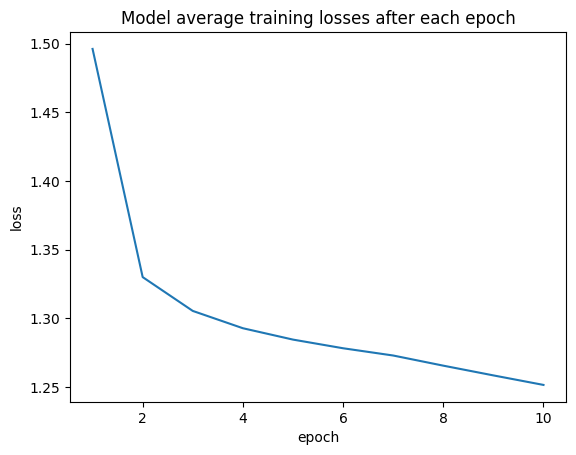

In [ ]:
# visualizing the training loss curve
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
loss_save_path = '/content/drive/MyDrive/CS167/datasets/rnn_model_' + file_name + '_losses.mat'
res = loadmat(loss_save_path)
train_losses = res['train_losses'][0]
vis = 1
if vis:
    plt.plot(range(1,len(train_losses)+1), train_losses)
    plt.title('Model average training losses after each epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


In [ ]:
# Step 6: Evaluate your model by testing its ability to generate new text that resembles Shakespearean language
# -----------------------------------------------------------------

class SimpleRNNv1(nn.Module):
  def __init__(self, vocab_size, hidden_size, output_size):
    super().__init__()
    # your network layer construction should take place here

    # add an embedding layer which will convert index to a raw character let's say (1 which stands for 'a') or (2 which stands for 'b') or (3 which stands for 'c') to a vector [or length vocab_size] for that character
    self.embedding        = nn.Embedding(vocab_size, vocab_size)
    self.lstm             = nn.LSTM(input_size=vocab_size, hidden_size=hidden_size, num_layers=3)
    self.classifier       = nn.Linear(hidden_size, output_size)

  def forward(self, x_sequence, hidden_state):
    # your code for RNN forward pass should take place here
    embedded_code         = self.embedding(x_sequence)
    output, hidden_state  = self.lstm(embedded_code, hidden_state)
    output                = self.classifier(output)

    return output, (hidden_state[0].detach(), hidden_state[1].detach())


def test_loop(model, seed_data, sequence_length = 1000):

    model.eval()          # set the model to evaluation mode for best practices
    hidden_state          = None
    start_index           = 0
    iteration             = 0

    # provide first few characters to initialize the hidden state
    seed_data_length      = len(seed_data)
    init_output, hidden_state = model(seed_data[0:seed_data_length-1], hidden_state)
    next_input = seed_data[seed_data_length-1]
    next_input = torch.unsqueeze(next_input, dim=0)

    # predict char one letter at a time
    for i in range(sequence_length):
      output, hidden_state = model(next_input, hidden_state)
      output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
      dist   = torch.distributions.Categorical(output)
      index  = dist.sample().item()
      #print("next character prediction is: ", index_to_vocab_dict[index])
      print(index_to_vocab_dict[index], end="")
      next_input[0] = index


    return None

# load the model
save_path             = '/content/drive/MyDrive/CS167/datasets/rnn_model_' + file_name + '.pth'
rnn_model             = SimpleRNNv1(vocab_size, 512, vocab_size)
rnn_model.to(device)
#checkpoint = torch.load(save_path, map_location=torch.device('cpu')) # loaded a trained model on 'cpu' directly
checkpoint = torch.load(save_path, map_location=torch.device(device)) # loaded a trained model
rnn_model.load_state_dict( checkpoint )


# provide an initial seed text to the test_loop() method for generating next sequence of characters
seed_text  = "hi ther"
encoding   = np.zeros(len(seed_text))
for i in range(len(seed_text)):
  encoding[i] = vocab_to_index_dict[seed_text[i].lower()]
for i in range(len(encoding)):
  cur_character = index_to_vocab_dict[encoding[i]]
  print("encoding: ", encoding[i], " and the corresponding character is: ", cur_character)
#seed_data           = torch.LongTensor(encoding) # loaded a trained model on 'cpu' directly
seed_data           = torch.LongTensor(encoding).to(device)
seed_data           = torch.unsqueeze(seed_data, dim=1)
test_loop(rnn_model, seed_data, sequence_length = 1000)

encoding:  20.0  and the corresponding character is:  h
encoding:  21.0  and the corresponding character is:  i
encoding:  1.0  and the corresponding character is:   
encoding:  32.0  and the corresponding character is:  t
encoding:  20.0  and the corresponding character is:  h
encoding:  17.0  and the corresponding character is:  e
encoding:  30.0  and the corresponding character is:  r
e
should he did this bleast wish knowine.

sebastian:
no arts, a sins,--whate'er he not?

prospero:
hath sweet more petible call'd sad toward on in
the sequer, that he cocks.

prospero:
that what the daughter any the commonth o' the gains!

katharina:
the cause o' things a blacker 'was again.

sebastian:
o lefy word is all.

miranda:
who, pound and mong!' i' the new-pates in warter.

antonio:
my swift walk an afemal to desire
at oncy.

another:
go, must reason, 'twixt the hope upon, it is your
daughter and disfian. mountening that hug!

sebastian:
rights in so both edule's virtue,
do mend up her to usu